In [94]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

In [95]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNELS = 3

In [96]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/drowsiness-dataset/train',
    seed = 123,
    shuffle = True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 2900 files belonging to 4 classes.


In [97]:
class_names = dataset.class_names
class_names


['Closed', 'Open', 'no_yawn', 'yawn']

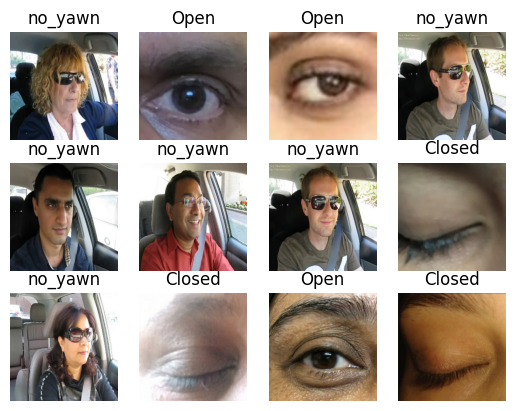

In [98]:
for image_batch, labels_name in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_name[i]])
        plt.axis('off')
        
plt.show()

In [99]:
def get_split_data(ds, train_split=0.8, test_splt=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_splt + val_split ) == 1
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In [100]:
train_ds, val_ds, test_ds = get_split_data(dataset)


In [101]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

72
10
9


In [102]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [103]:
resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255),  # Rescaling the image pixels to [0, 1]
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)  # Resizing the images
])


In [104]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])


In [105]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
   
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
   
    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [106]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [107]:
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 30, 30, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 28, 28, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 14, 14, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 12, 12, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (32, 6, 6, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 4608)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 128)              │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 128)              │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 4)                │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 979,396 (3.74 MB)

 Trainable params: 979,140 (3.74 MB)

 Non-trainable params: 256 (1.00 KB)

In [108]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5916 - loss: 0.8746 - val_accuracy: 0.6736 - val_loss: 0.6530
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7684 - loss: 0.4861 - val_accuracy: 0.8785 - val_loss: 0.4084
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8147 - loss: 0.3997 - val_accuracy: 0.6354 - val_loss: 0.8316
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8367 - loss: 0.3659 - val_accuracy: 0.8750 - val_loss: 0.4091
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8970 - loss: 0.2731 - val_accuracy: 0.9514 - val_loss: 0.3968
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9314 - loss: 0.1883 - val_accuracy: 0.9826 - val_loss: 0.1531
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9642 - loss: 0.1181 - val_accuracy: 0.9688 - val_loss: 0.0982
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9731 - loss: 0.1006 - val_accuracy: 

Text(0.5, 1.0, 'Training and Validation loss')

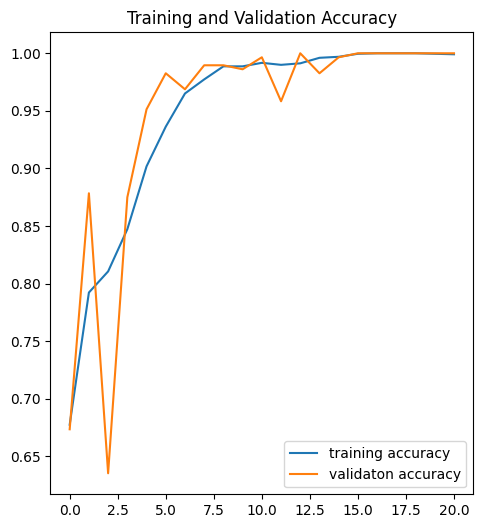

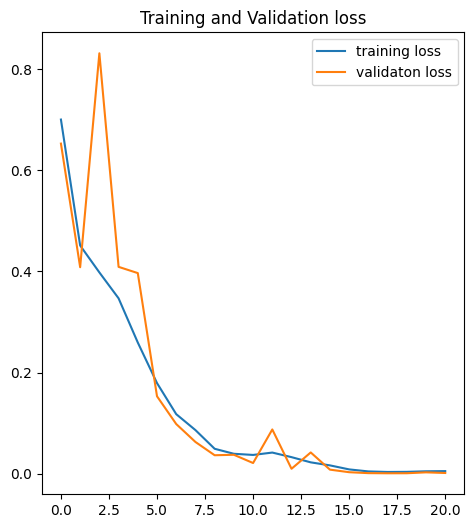

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss =history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = len(acc)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'training accuracy')
plt.plot(range(EPOCHS), val_acc, label='validaton accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label='validaton loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

In [110]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidance = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidance


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


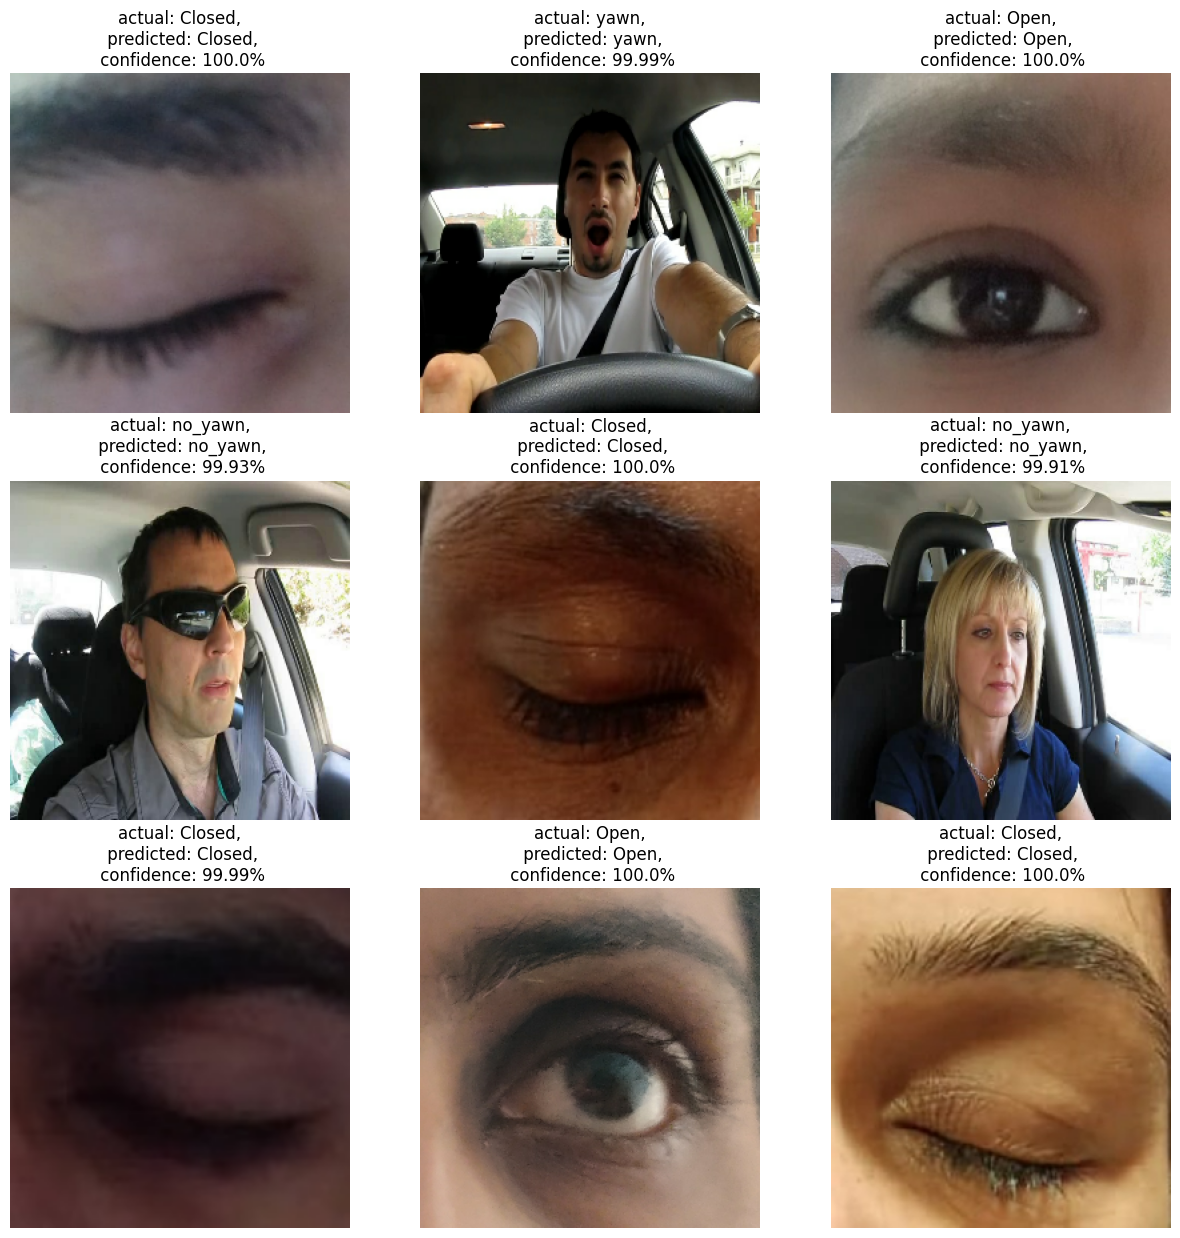

In [111]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual: {actual_class},\n predicted: {predicted_class},\n confidence: {confidence}%")
        plt.axis('off')